## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [70]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
#from model3D import *
from model3D_small import *
import math
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils  import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Data Description

In [ ]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

In [ ]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

In [ ]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

In [ ]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

In [90]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array_colors = []
    for idx, path in enumerate(paths): # bedre me enumerate her?
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        frames_to_skip = (int(vc.get(cv2.CAP_PROP_FRAME_COUNT))-1)/frames_each_video
        frames_to_skip=math.floor(frames_to_skip)
        """ print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT)))
        if(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))!=300):
            print(path)
            print(int(vc.get(cv2.CAP_PROP_FRAME_COUNT))) """
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (53, 30))
                video.append((cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255))
            else:
                vc.release()
                break
        video_array_colors.append(np.array(video))
    return np.array(video_array_colors)

training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
complete_paths.sort()
vid_arr_col = get_frames_v1(paths=complete_paths, frames_each_video=100, video_amount=70)


/var/folders/0b/kp7mjww52gv0qrxc8_6p5dgh0000gn/T/ipykernel_58089/63456889.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(video_array_colors)


In [ ]:
print(vid_arr_col.shape)
#vid_arr_gray = np.expand_dims(vid_arr_gray, axis=-1)
#print(vid_arr_gray.shape)
print(vid_arr_col[0][0])

In [ ]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)
y = to_categorical(y, num_classes=None).astype(int)
y

In [ ]:
print(f"Amount of Videos: {len(vid_arr_col)}")
print(f"Frames for videos: {[len(vid_arr_col[i]) for i in range(len(vid_arr_col))]}")

In [ ]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()

plot_video(vid_arr_col[0], (30,5), 2, 5)

In [ ]:
from sklearn.manifold import TSNE
frames_list = vid_arr_col[0]
frames_array = np.array([frame.flatten() for frame in frames_list])
# Instantiate t-SNE object with desired parameters
print(2)
tsne = TSNE(n_components=2, perplexity=10, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

In [ ]:
# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,20))
plt.show()

In [ ]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])
first_frame_formatted = format_frames(vid_arr_col)
first_frame_formatted.shape

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [ ]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

In [ ]:
def build_3D_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=16, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=8, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(2 ,activation="softmax"))
    return model

In [52]:
def test_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=32, kernel_size=(2,2,2),input_shape=input_data.shape[1:],
                activation='relu',
                padding='same', data_format='channels_last'))
    model.add(layers.BatchNormalization())
    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))



    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    model.add(layers.Flatten())

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32,activation='elu'))

    model.add(layers.Dense(2,activation='sigmoid'))
    return model

In [53]:
test_m = test_model(vid_arr_col)
test_m.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 30, 53, 32)    800       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 30, 53, 32)   128       
 chNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 10, 30, 53, 16)    12352     
                                                                 
 batch_normalization_13 (Bat  (None, 10, 30, 53, 16)   64        
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 10, 30, 53, 16)    0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 15, 26, 16)   

In [54]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
test_m.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [78]:
test_m.fit(vid_arr_col, y[:vid_arr_col.shape[0]],epochs=10, batch_size=10, verbose=2, class_weight=class_weights)

Epoch 1/10
10/10 - 41s - loss: 0.3420 - accuracy: 0.8600 - 41s/epoch - 4s/step
Epoch 2/10
10/10 - 32s - loss: 0.3546 - accuracy: 0.7900 - 32s/epoch - 3s/step
Epoch 3/10
10/10 - 28s - loss: 0.4746 - accuracy: 0.8400 - 28s/epoch - 3s/step
Epoch 4/10
10/10 - 28s - loss: 0.3243 - accuracy: 0.8200 - 28s/epoch - 3s/step
Epoch 5/10
10/10 - 29s - loss: 0.2610 - accuracy: 0.8500 - 29s/epoch - 3s/step
Epoch 6/10
10/10 - 28s - loss: 0.3257 - accuracy: 0.8700 - 28s/epoch - 3s/step
Epoch 7/10
10/10 - 28s - loss: 0.2385 - accuracy: 0.9000 - 28s/epoch - 3s/step
Epoch 8/10
10/10 - 28s - loss: 0.2795 - accuracy: 0.8800 - 28s/epoch - 3s/step
Epoch 9/10
10/10 - 28s - loss: 0.3425 - accuracy: 0.8500 - 28s/epoch - 3s/step
Epoch 10/10
10/10 - 29s - loss: 0.2842 - accuracy: 0.8700 - 29s/epoch - 3s/step


In [79]:
pred_y = test_m.predict(vid_arr_col)

4/4 [==============================] - 8s 2s/step


In [80]:
pred_y

array([[0.5452956 , 0.58010143],
       [0.69432515, 0.5103222 ],
       [0.6898619 , 0.5498576 ],
       [0.5672844 , 0.5502688 ],
       [0.4724289 , 0.67823744],
       [0.6684107 , 0.51984555],
       [0.5200045 , 0.56388307],
       [0.47418377, 0.75669813],
       [0.72182727, 0.32549965],
       [0.6517231 , 0.47415045],
       [0.5708572 , 0.54916346],
       [0.8069315 , 0.40341088],
       [0.44861883, 0.73705006],
       [0.7271262 , 0.6431659 ],
       [0.47014728, 0.6755512 ],
       [0.6798664 , 0.67255026],
       [0.45384347, 0.7337148 ],
       [0.79489064, 0.5132833 ],
       [0.470556  , 0.596708  ],
       [0.6411012 , 0.5683278 ],
       [0.72784674, 0.35633662],
       [0.6141314 , 0.6496532 ],
       [0.4730532 , 0.72429895],
       [0.6476595 , 0.4716566 ],
       [0.67235714, 0.6917969 ],
       [0.67030287, 0.38449252],
       [0.736177  , 0.42107755],
       [0.52425   , 0.57936275],
       [0.56352276, 0.553846  ],
       [0.5896071 , 0.6118345 ],
       [0.

In [82]:
actual_y = np.argmax(y[:vid_arr_col.shape[0]], axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.288     0.895     0.436        19
           1      0.951     0.481     0.639        81

    accuracy                          0.560       100
   macro avg      0.620     0.688     0.538       100
weighted avg      0.825     0.560     0.601       100



In [83]:
pred_y.sum()

41

In [84]:
actual_y

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [85]:
cfm = confusion_matrix(actual_y, pred_y)

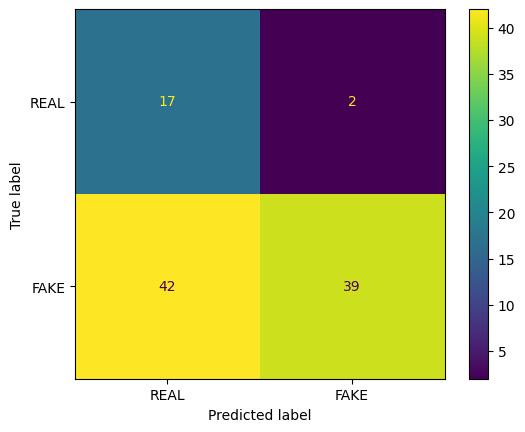

In [86]:
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()

In [87]:
model_3D_col = build_3D_model(vid_arr_col)
model_3D_col.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 10, 30, 53, 64)    5248      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 5, 15, 27, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 5, 15, 27, 32)     55328     
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 3, 8, 14, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 3, 8, 14, 16)      13840     
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 2, 4, 7, 16)     

In [88]:
loss = "binary_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [89]:
model_3D_col.fit(vid_arr_col, y[:vid_arr_col.shape[0]],epochs=10, batch_size=10, verbose=2)

Epoch 1/10
10/10 - 37s - loss: 3485.9014 - accuracy: 0.6200 - 37s/epoch - 4s/step
Epoch 2/10
10/10 - 34s - loss: 0.5661 - accuracy: 0.8100 - 34s/epoch - 3s/step
Epoch 3/10
10/10 - 38s - loss: 0.5054 - accuracy: 0.8100 - 38s/epoch - 4s/step
Epoch 4/10


KeyboardInterrupt: 